<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/NB6_PyTorch_Segmentation_MultiChannel_(DeepLabV3%2B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Open tasks (TODOs):


1. fix in this NB:
- #TODO Show class distribution comparison
- #TODO check pytorch splits builtin
- #TODO move final version to libs


## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -q rasterio imagecodecs fastai albumentations torchmetrics

     |████████████████████████████████| 19.3 MB 7.3 MB/s 
     |████████████████████████████████| 31.0 MB 1.1 MB/s 
     |████████████████████████████████| 419 kB 74.5 MB/s 
     |████████████████████████████████| 631 kB 48.3 MB/s 


In [3]:
# Python General
import os
import gc
import sys
import glob
import random
import shutil
import numpy as np
import pandas as pd
import pprint as pp
from PIL import Image
from pathlib import Path
from copy import deepcopy
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix

#for augmentations
import albumentations as A
from fastai.vision.all import *

#Torch
import torch
import torchmetrics
from torch import nn
from torchmetrics import Dice
from torchvision import transforms

#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [4]:
SEED=777
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Env directories

In [5]:
REMOTE_EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/'
LOCAL_EXPORT_DIR='/content/'
NB_DIR = '/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks/'
os.chdir(NB_DIR)
sys.path.append(NB_DIR)


#FULL DATASET
# EXPORT_DIR = LOCAL_EXPORT_DIR
esm_aligned = os.path.join(LOCAL_EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(LOCAL_EXPORT_DIR,'s2_resized/')

# s2_resized_dev = os.path.join(LOCAL_EXPORT_DIR,'s2_resized_dev')
# esm_aligned_dev = os.path.join(LOCAL_EXPORT_DIR,'esm_aligned_dev')

s2_resized_test = os.path.join(LOCAL_EXPORT_DIR ,'s2_resized_test/')
esm_aligned_test = os.path.join(LOCAL_EXPORT_DIR ,'esm_aligned_test/')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #GOOD FOR DEBUGGING
print('Using device:', device)

Using device: cuda


In [7]:
# !rm -rf /content/esm_aligned
# !rm -rf /content/s2_resized

!cp -r -n {REMOTE_EXPORT_DIR}/s2_resized /content/
!cp -r -n {REMOTE_EXPORT_DIR}/esm_aligned /content/

#copy test dir anyway
# !rm -rf /content/esm_aligned_test
# !rm -rf /content/s2_resized_test
!cp -r -n {REMOTE_EXPORT_DIR}/s2_resized_test /content/
!cp -r -n {REMOTE_EXPORT_DIR}/esm_aligned_test /content/

In [8]:
# !mv {REMOTE_EXPORT_DIR}/s2_resized {REMOTE_EXPORT_DIR}/s2_resized_orig
# !mv {REMOTE_EXPORT_DIR}/esm_aligned {REMOTE_EXPORT_DIR}/esm_aligned_orig
# !cp -r /content/s2_resized/ {REMOTE_EXPORT_DIR}
# !cp -r /content/esm_aligned/ {REMOTE_EXPORT_DIR}
# !cp -r /content/s2_resized_test/ {REMOTE_EXPORT_DIR}
# !cp -r /content/esm_aligned_test/ {REMOTE_EXPORT_DIR}

In [9]:
!ls {REMOTE_EXPORT_DIR}/s2_resized | wc -l
!ls {REMOTE_EXPORT_DIR}/esm_aligned | wc -l
!ls {REMOTE_EXPORT_DIR}/s2_resized_test | wc -l
!ls {REMOTE_EXPORT_DIR}/esm_aligned_test | wc -l

640
640
60
60


In [10]:
#Our implementation (can be called after setting env directories)
from libs.preprocess import *
# from libs.metrics import *
# from libs.multichannel import *
# from libs.metrics import _fast_hist

## Train  Test Split

In [11]:
# !mv {REMOTE_EXPORT_DIR}/s2_resized_test/*.tif {REMOTE_EXPORT_DIR}/s2_resized
# !mv {REMOTE_EXPORT_DIR}/esm_aligned_test/*.tif {REMOTE_EXPORT_DIR}/esm_aligned
# !mv /content/esm_aligned_test/*.tif /content/esm_aligned
# !mv /content/s2_resized_test/*.tif /content/s2_resized
# !rm -rf {esm_aligned_test}
# !rm -rf {s2_resized_test}

# DEV
# !mv /content/s2_resized_dev/*.tif /content/s2_resized
# !mv /content/esm_aligned_dev/*.tif /content/esm_aligned
# !rm -rf {esm_aligned_dev}
# !rm -rf {s2_resized_dev}

In [12]:
NUM_DEV=0#50
NUM_TST=60

#TODO check pytorch splits builtin

def create_dev_set(src_imgs_dir,src_masks_dir,tgt_imgs_dir,tgt_masks_dir,valid_num=50):

  if(os.path.isdir(tgt_imgs_dir)):
    print('{} Directory exists,\n exiting.(To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)'.format(tgt_imgs_dir))
    target = os.listdir(tgt_imgs_dir)
    number_files = len(target)
    print(number_files)
  else:
    print('Creating ',tgt_imgs_dir)
    print('Creating ',tgt_masks_dir)
    os.makedirs(tgt_imgs_dir)
    os.makedirs(tgt_masks_dir)
    s2_source = src_imgs_dir
    esm_source = src_masks_dir
    files = os.listdir(s2_source)
    no_of_files = valid_num #int(len(files) *valid_pct)

    for file_name in random.sample(files, no_of_files):
        shutil.move(os.path.join(s2_source, file_name), tgt_imgs_dir)
        shutil.move(get_matching_mask_path(file_name,esm_source), tgt_masks_dir)

#Running without DEV only train and test sets 80-20
# create_dev_set(src_imgs_dir=s2_resized,src_masks_dir=esm_aligned,
#                tgt_imgs_dir=s2_resized_dev,
#                tgt_masks_dir=esm_aligned_dev,
#                valid_num=NUM_DEV)
create_dev_set(src_imgs_dir=s2_resized,src_masks_dir=esm_aligned,
               tgt_imgs_dir=s2_resized_test,
               tgt_masks_dir=esm_aligned_test,
               valid_num=NUM_TST)

/content/s2_resized_test/ Directory exists,
 exiting.(To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)
60


In [13]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
trn_esm = glob.glob(os.path.join(esm_aligned,'*.tif'))
trn_esm_number_files = len(trn_esm)
print('{} train mask files in {}'.format(trn_esm_number_files,esm_aligned))
# dev = glob.glob(os.path.join(s2_resized_dev,'*.tif'))
# dev_number_files = len(dev)
# print('{} dev files in {}'.format(dev_number_files,s2_resized_dev))
tst = glob.glob(os.path.join(s2_resized_test,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,s2_resized_test))
tst_esm = glob.glob(os.path.join(esm_aligned_test,'*.tif'))
tst_esm_number_files = len(tst_esm)
print('{} test mask files in {}'.format(tst_esm_number_files,esm_aligned_test))

640 train files in /content/s2_resized/
640 train mask files in /content/esm_aligned/
60 test files in /content/s2_resized_test/
60 test mask files in /content/esm_aligned_test/


## Train Test band distribution

In [14]:
trn_stats_mean_df,trn_stats_std_df = calc_stats_dfs(s2_resized)       
# trn_stats_mean_df.head(3)

  0%|          | 0/640 [00:00<?, ?it/s]

In [15]:
tst_stats_mean_df,tst_stats_std_df = calc_stats_dfs(s2_resized_test)       
# tst_stats_mean_df.head(3)

  0%|          | 0/60 [00:00<?, ?it/s]

Train (blue) vs. Test (red) Band value distribution comparision


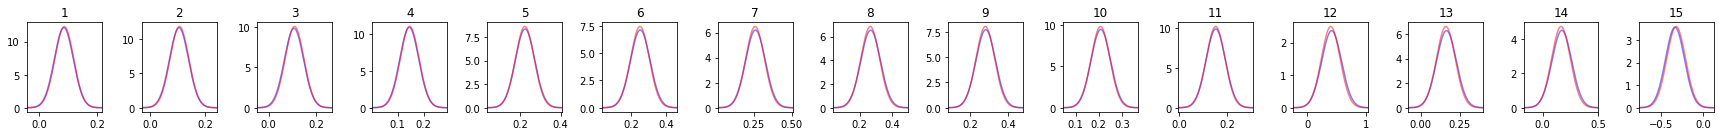

In [16]:
plot_bands_dist(trn_stats_mean_df,trn_stats_std_df,tst_stats_mean_df,tst_stats_std_df)
print('Train (blue) vs. Test (red) Band value distribution comparision')

## Load Images and Masks


In [17]:
def load_tif_files(dir,title):
  files = glob.glob(os.path.join(dir,'*.tif'))
  print('{} image files in {}'.format(len(files),dir))
  return files

train_images = load_tif_files(s2_resized,'Train')
# dev_images = load_tif_files(s2_resized_dev,'Dev')
test_images = load_tif_files(s2_resized_test,'Test')

640 image files in /content/s2_resized/
60 image files in /content/s2_resized_test/


In [18]:
#check a sample of the expected image and matching mask both ways
sample_mask = get_matching_mask_path(train_images[0],esm_aligned)
assert sample_mask != None
sample_image = get_matching_img_path(sample_mask,s2_resized)
assert sample_image != None
sample_image,sample_mask

('/content/s2_resized/R_6_592.tif', '/content/esm_aligned/ESM_592.tif')

## MultiChannel Dataset and Scaler

In [19]:
stats_mean_df = pd.read_csv('down_stats_mean_df.csv',header=0,index_col=0)
def get_global_chn_mean(band):
  '''
  Returns the global mean of a channel based on the statistics calculated in preprocessing
  Used for imputation of nan values in expoerted images (last resort...)
  '''
  return stats_mean_df[band].mean()
  # print('Band:{} Mean:{:.6f}'.format(band,stats_mean_df[band].mean()))

In [20]:
def scale_multi_bands_array(image_path,new_min=0.,new_max=1.,method='minmax',fillnan=False): # Default std and min-max
  '''
  A Min Max or Standard Multi Channel Scaler for images
  Scales each channel separately to a given range
  Returns: a tensor with the scaled multi channel image 
  '''
  with rio.open(image_path) as img:
    n_bands,height,width = img.count,img.shape[0],img.shape[1]
    norm_img = np.zeros((n_bands,height,width),dtype=np.float)
    if(method=='minmax'):
      scaler = MinMaxScaler()
    else:
      scaler = StandardScaler()

    for b in range(1,img.count+1):
      img_bnd = img.read(b)
      # print('>>B 0',img_bnd.shape)
      #Fill nans with mean of the channel
      if((fillnan) & (np.isnan(img_bnd).sum()>0)):
          # print('>>B4 1 #nans',np.isnan(img_bnd).sum())
          not_nan =(np.isnan(img_bnd)==False)
          # print('>>B4 2 nan idx shape',not_nan.shape)
          #try calculating mean from non nan values
          mean_chn = img_bnd[not_nan].mean()
          # print('>>B4 3 mean band',mean_chn)
          # print(b,'mean chan:',mean_chn)
          if(mean_chn==np.nan):
            #get global mean of the channel calculated in preprocessing
            mean_chn = get_global_chn_mean(b)
            # print(b,'global mean chan:',mean_chn)
          img_bnd = np.nan_to_num(img_bnd,nan=mean_chn)
          # print('>>B4 3 img band shape',img_bnd.shape)
          # print('AF',np.isnan(img_bnd).sum())
      # print('\tA',img_bnd.shape)
      if(np.isnan(img_bnd).sum()>0):
        print(image_path,'True',b,img_bnd.shape,img_bnd)
      # norm_img[b-1,:,:] = scaler.fit_transform(img_bnd)

      if(method=='minmax'):
        v_min, v_max = np.min(img_bnd), np.max(img_bnd)
        # print(b,'vmin vmax',v_min, v_max)
        norm_img[b-1,:,:] = (img_bnd - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
        # print(b,'after',(img_bnd - v_min)/(v_max - v_min)*(new_max - new_min) + new_min)
      else:
        #Standartization 
        scaler.fit(img_bnd)
        norm_img[b-1,:,:] = scaler.transform(img_bnd)
    assert(norm_img.shape==(n_bands,height,width))
    return torch.tensor(norm_img,dtype=torch.float)

In [21]:
def get_matching_mask_path(img_name,mask_dir=None):
    '''
    Return the matching mask of a given image from the masks directory
    '''
    split = img_name.split('_')
    mask_file = glob.glob(mask_dir + '/*_'+split[-1])
    return mask_file[0]

def get_mask_as_array(img_name,mask_path,p2c,merge_bg=False):
  '''
  Returns a matching mask for an image as tensor
  '''
  fn = get_matching_mask_path(img_name,mask_path)
  with rio.open(fn) as msk:
    mask_arr = msk.read(1)
    new_msk = np.zeros((mask_arr.shape[0],mask_arr.shape[0]),dtype=np.int)

    for i, val in enumerate(p2c):
      new_msk[mask_arr==p2c[i]] = val
    if(merge_bg):
      new_msk[msk==1] = 0 #merge 1 to 0
    return fn,torch.tensor(new_msk,dtype=int)

## Augmentations
Required for multi channel images (and their masks) using [Albumenations](https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task)

In [22]:
# #TODO move to multichannel.py
#From https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task

width=300
height=300
class SegmentationAlbumentationsTransform(ItemTransform):
  
    def __init__(self, aug): self.aug = aug
    def encodes(self, img,mask):
        # for albumentations to work correctly, the channels must be at the last dimension
        aug = self.aug(image=np.array(img.permute(1,2,0)), mask=np.array(mask))
        return TensorImage(aug['image'].transpose(2,0,1)), TensorMask(aug['mask'])

prob=0.5
#Half size is a popular choice of augmenation for segmentation tasks
aug_pipe = A.Compose([
                      # A.RandomSizedCrop(min_max_height=(150, 150), height=height, width=width, p=prob),
                      # A.PadIfNeeded(min_height=height, min_width=width, always_apply=True), 
                      A.VerticalFlip(p=prob),
                      A.RandomRotate90(p=prob)])

# # Create our class with this aug_pipe
aug = SegmentationAlbumentationsTransform(aug_pipe)

augs_list = []
for a in aug_pipe:
  augs_list.append(a.__class__.__name__)
augs_list

['VerticalFlip', 'RandomRotate90']

In [23]:
class S2ESMDataset(torch.utils.data.Dataset):
    '''
    A pytorch dataset for serving multi channel S1 images and ESM matching masks
    images - list of images to load (converted to tensors)
    mask_path - matching masks directory
    '''
    def __init__(self,images,mask_path,code2class,aug=None):
        super(S2ESMDataset, self).__init__()
        self.images = [(img,scale_multi_bands_array(img,method='minmax')) for img in tqdm(images)]
        # self.images = [(img,scale_multi_bands_array(img,method='std')) for img in tqdm(images)]
        self.masks = [get_mask_as_array(image[0],mask_path,code2class) for image in tqdm(self.images)]
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def get_one(self,idx):
      return self.images[idx], self.masks[idx]
    
    def get_one_with_aug(self,idx):
      return self.__getitem__(idx)
    
    def __getitem__(self, idx):
      image = self.images[idx]
      img_nm = image[0]
      mask = self.masks[idx]
      msk_nm = mask[0]
      if (self.aug is not None):
        transformed = self.aug.encodes(image[1],mask[1])
        image = (img_nm,torch.tensor(transformed[0],dtype=torch.float))
        mask = (msk_nm,torch.tensor(transformed[1],dtype=torch.long))
      return image, mask
      # return self.images[idx],self.masks[idx]


## Classes 

- 250 for non-residential **(Red)**
- 255 for residential     **(Blue)**
- 1 for all other areas   **(Green , merged into 0)**
- 0 for no data           **(Green also)**

codes decoder dictionary (0,1,2,3)->(0,1,250,255)

In [24]:
CMAP='brg_r'

In [25]:
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}
else:
  code2class = {0:0,1:1,2:250,3:255}
  class2code={0:0,1:1,250:2,255:3}
  class2desc={0:'No Data',1:'Other',250:'Non Resi',255:'Resi'}

In [26]:
%%time

# train_ds = S2ESMDataset(train_images,esm_aligned,code2class,aug=None) #No augmentations
train_ds = S2ESMDataset(train_images,esm_aligned,code2class,aug=aug) #add augmentations
# dev_ds   = S2ESMDataset(dev_images,esm_aligned_dev,code2class)
test_ds  = S2ESMDataset(test_images,esm_aligned_test,code2class)

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 30.2 s, sys: 3.62 s, total: 33.9 s
Wall time: 19.2 s


In [27]:
#TODO move to libs

def normalize(image,vmin=0.0,vmax=0.3):
  '''
  RGB data was exported in the range between 0 and 0.3 for visualization only
  '''
  return (image - vmin)/(vmax-vmin) + vmin

def display_image(image_path,bands=[3,2,1],title=None,ax=None):
  '''
  Displaying RBG images by Red,Green,Blue in this order
  '''
  img = None
  with rio.open(image_path) as img1:
    img = img1.read(bands)
    if(bands==[1]):
      # print('single band')
      show(img, title=title,ax=ax)
    elif(len(bands)>3):
      # print('multi band')
      show(img, title=title,ax=ax)
    else:
      # print('rgb')
      show(normalize(img), title=title,ax=ax)
    # print(title,len(img.indexes),'bands')
  return img

In [28]:
img1_arr,msk1_arr = train_ds.get_one(1)
img1_arr[0],img1_arr[1].shape,msk1_arr[0],msk1_arr[1].shape

('/content/s2_resized/R_4_390.tif',
 torch.Size([15, 300, 300]),
 '/content/esm_aligned/ESM_390.tif',
 torch.Size([300, 300]))

Show one sample , normalized and RGB

In [29]:
def permute_4_display(img_arr):
  return torch.permute(normalize(torch.tensor(img_arr[1:4,:,:],dtype=float)), (1, 2, 0)).numpy()

def show_one(ds,index,images,preds=None,cmap=CMAP,with_aug=False):
  if(with_aug):
    img1_arr,msk1_arr = ds.get_one_with_aug(index)
  else:
    img1_arr,msk1_arr = ds.get_one(index)
  f,axs = plt.subplots(1,4 if preds!=None else 3,figsize=(16,5))
  one_norm_img = permute_4_display(img1_arr[1])
  print(img1_arr[1].shape,msk1_arr[1].shape)
  one_mask =  msk1_arr[1]
  display_image(images[index],ax=axs[0])
  axs[0].set_title('Orig RGB')
  axs[1].imshow(one_norm_img)
  axs[1].set_title('Scaled')
  axs[2].imshow(one_mask,cmap=cmap)
  axs[2].set_title('True')
  if(preds!=None):
    axs[3].imshow(preds[0][index],cmap=cmap)
    axs[3].set_title('Pred')
  plt.suptitle('Augmented:{}'.format(with_aug))
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


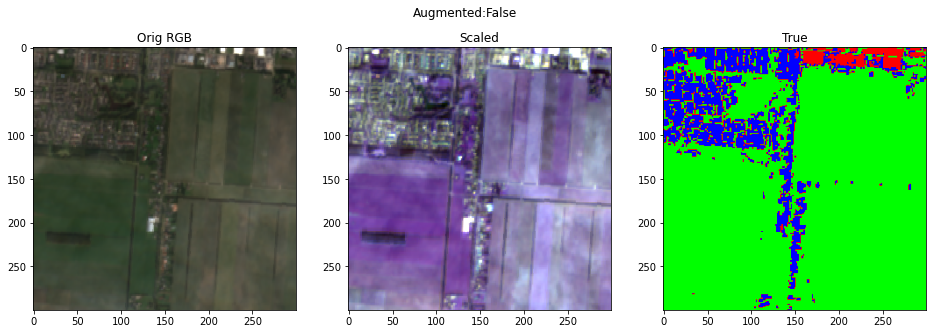

In [30]:
show_one(train_ds,2,train_images,cmap=CMAP)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


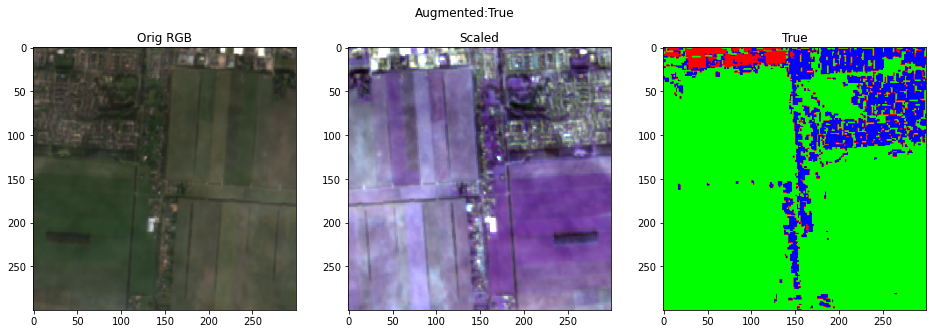

In [31]:
show_one(train_ds,2,train_images,cmap=CMAP,with_aug=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


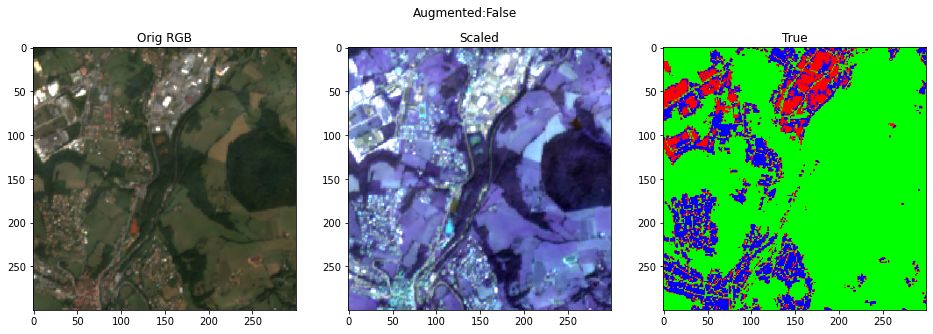

In [32]:
show_one(train_ds,12,train_images,cmap=CMAP)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


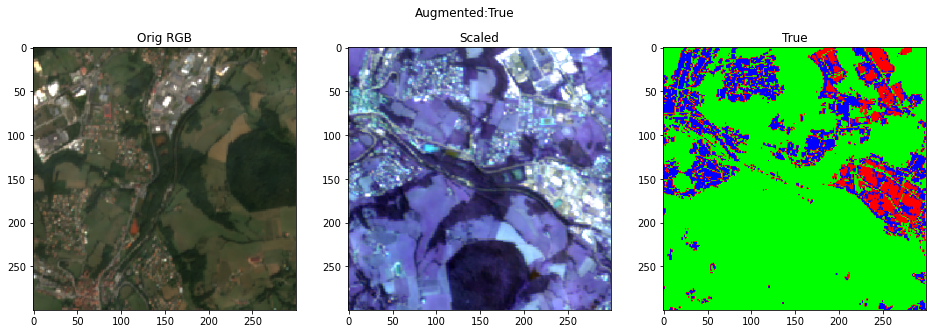

In [33]:
show_one(train_ds,12,train_images,cmap=CMAP,with_aug=True)

## Create Dataloaders (Batch size)

In [34]:
BS=16
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BS, shuffle=True)
# dev_dl = torch.utils.data.DataLoader(dev_ds, batch_size=NUM_DEV, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BS, shuffle=False)
print('Train batches:',len(train_dl))
# print('Dev batches:',len(dev_dl))
print('Test batches:',len(test_dl))

Train batches: 40
Test batches: 4


## Train loop


In [35]:
def clear_cache():
  gc.collect()
  torch.cuda.empty_cache()

def end_epoch(e,train_loss,dev_loss,train_dice,dev_dice,verbose):
  if (verbose) & (e % 3 == 1):   #  report every 5 epochs
    print("Epoch {epoch_id}".format(epoch_id=e),end='\t- ')
    print("Train loss: {:.3f}".format(train_loss),end=' - ')
    print("Dev loss: {:.3f}".format(dev_loss),end=' - ')
    print("Train dice: {:.3f}".format(train_dice),end='- ')
    print("Dev dice: {:.3f}".format(dev_dice))  
    # print("\nEpoch {epoch_id}".format(epoch_id=e))
    # print("Train loss  : {:.3f}".format(train_loss),end=',   ')
    # print("Dev loss    : {:.3f}".format(dev_loss))
    # print("Train dice  : {:.3f}".format(train_dice),end=',   ')
    # print("Dev dice    : {:.3f}".format(dev_dice))
    clear_cache()        

In [36]:
def train_loop(model, n_epochs, train_dl, dev_dl,optimizer, loss_fn,
               early_stopping=15,verbose=False,n_classes=3):
  #Init once per training
  model.train()
  loss_train_arr,loss_dev_arr,dice_train_arr,dice_dev_arr,all_epochs_dice_arr,all_epochs_dev_dice_arr= [],[],[],[],[],[]
    
  epochs_without_improvement,best_dev_loss,best_dev_dice= 0,None,None

  model = model.to(device)
  criterion = loss_fn.to(device)
  dice = torchmetrics.Dice(average='weighted',num_classes=n_classes)

  # Train loop
  print('Training (with{} Dev set)'.format('out' if(dev_dl==None) else ''))
  for e in tqdm(range(1, n_epochs + 1)):
      train_loss   = 0
      train_dice     = 0
      
      for train_input, train_label in train_dl:
          optimizer.zero_grad()
          
          # Send tensors to GPU
          image_tensor   = train_input[1].to(device)
          mask_tensor  = train_label[1].to(device) 

          pred = model.forward(image_tensor)['out']

          loss   = criterion(pred, mask_tensor)
          loss.backward()
          optimizer.step()
          # agg  batch results
          train_loss += loss.item()
          #find the max of every pixel prediction
          pred_cls =  np.argmax(pred.detach().cpu() , axis = 1)
          batch_dice = dice(mask_tensor.cpu(), pred_cls.cpu())
          dice_train_arr.append(batch_dice)
      
      # Agg epoch results 
      train_loss = train_loss / len(train_dl)            
      loss_train_arr.append(train_loss)
      train_dice = np.mean(np.array(dice_train_arr))
      all_epochs_dice_arr.append(train_dice)

      # Dev  evaluation 
      dev_loss ,dev_dice = 0,0
      
      #no validation set use only train
      if(dev_dl==None):
        # end_epoch(e,train_loss,dev_loss,train_dice,dev_dice,verbose)
        if not best_dev_loss or train_loss < best_dev_loss:  
        # if not best_dev_dice or train_dice > best_dev_dice:   
            best_train_loss = train_loss
            best_dev_loss = train_loss
            best_train_dice  = train_dice
            best_dev_dice    = train_dice
            epochs_without_improvement = 0
            best_state_dict = deepcopy(model.state_dict())
        else:
            epochs_without_improvement += 1
        
        #end epoch reporting    
        end_epoch(e,train_loss,dev_loss,train_dice,dev_dice,verbose)
        
        if epochs_without_improvement == early_stopping:
            print ("\nEarly stoping after {} epochs. Dev loss did not imporve for more than {} epcochs".format(e,early_stopping))
            break
        #no dev set training
        continue
        
      with torch.no_grad():
          for dev_input, dev_label in dev_dl:
              # Send tensors to GPU
              dev_input   = dev_input[1].to(device)
              dev_label  = dev_label[1].to(device)

              # predict 
              dev_pred = model(dev_input)['out']
              #loss
              loss   = criterion(dev_pred, dev_label)
              
              dev_loss   += loss.item()
              # Agg results
              #find the max of every pixel prediction
              dev_pred_cls =  np.argmax(dev_pred.detach().cpu() , axis = 1)
              batch_dev_dice = dice(dev_label.cpu(), dev_pred_cls.cpu())
              dice_dev_arr.append(batch_dev_dice)

          # Agg epoch results 
          dev_loss = dev_loss / len(dev_dl)         
          loss_dev_arr.append(dev_loss)
          dev_dice = np.mean(np.array(dice_dev_arr))
          all_epochs_dev_dice_arr.append(dev_dice)
         
      # Early Stop and best model save 
      #if not best_dev_loss or dev_loss < best_dev_loss:  
      if not best_dev_dice or dev_dice > best_dev_dice:   
          best_train_loss = train_loss
          best_dev_loss   = dev_loss
          best_train_dice  = train_dice
          best_dev_dice    = dev_dice
          epochs_without_improvement = 0
          #print ("Achieved lower test loss  , save model  at epoch number {} ".format(e + 1) )
          best_state_dict = deepcopy(model.state_dict())
      else:
          epochs_without_improvement += 1

      if epochs_without_improvement == early_stopping:
          print ("\nEarly stoping after {} epochs. Dev loss did not imporve for more than {} epcochs".format(e,early_stopping))
          break

      #end epoch reporting    
      end_epoch(e,train_loss,dev_loss,train_dice,dev_dice,verbose)

                
  # Finish  training 
  model.load_state_dict(best_state_dict)
  if (verbose):
      print('\nFinished Training:')
      print('Train loss={:.3f}, Dev loss={:.3f}'.format(best_train_loss ,best_dev_loss ))
      print('Train dice={:.3f}, Dev dice={:.3f}'.format(best_train_dice ,best_dev_dice ))

  return loss_train_arr , loss_dev_arr , all_epochs_dice_arr , all_epochs_dev_dice_arr

## TRAINING - Hyperparams


In [37]:
# for param in model_deeplab.named_parameters():
#   if(param[0]=='backbone.conv1.weight'):
#     print(param[1].shape)

In [38]:
n_epochs=100
n_channels = 15
LR=1e-04
WD=1e-03
# BETAS=(0.5,0.5)
FINE_TUNE = False
pretrained=False
n_classes=len(class2code)

#TODO
#  check what was the kernel size before the change below 64???
#  check aug + dropout

model_deeplab = torch.hub.load('pytorch/vision:v0.13.0',
                               'deeplabv3_resnet50',
                               pretrained=pretrained,
                               num_classes=n_classes)
model_deeplab.backbone.conv1 = nn.Conv2d(in_channels=n_channels,
                                         out_channels=64,
                                         kernel_size=7,
                                         stride = 2,
                                         padding= 3,
                                         bias=False)
print('Updated input layer to multi channel:',model_deeplab.backbone.conv1)

optimizer = torch.optim.AdamW(model_deeplab.parameters(), lr=LR,weight_decay=WD)

loss_fn = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /root/.cache/torch/hub/v0.13.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Updated input layer to multi channel: Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [ ]:
%%time

clear_cache()

def load_pretrained():
    model_deeplab.load_state_dict(torch.load(FINAL_MODEL_PATH),strict=False)
    print('loaded model from:',FINAL_MODEL_PATH)
    return model_deeplab.to(device)
    
FINAL_MODEL_PATH=NB_DIR +'../models/deeplab_final_model.pth'
final_states_dict_file = Path(FINAL_MODEL_PATH)
INFERECE_MODE=final_states_dict_file.is_file() and not FINE_TUNE
print('Inference Mode:',INFERECE_MODE,', Fine tuning:',FINE_TUNE)

if(INFERECE_MODE):
  print('Inference mode: skipping training, loading model states dict...')
  model_deeplab = load_pretrained()
else:
  if(FINE_TUNE):
    model_deeplab = load_pretrained()
  loss_train_arr = [];loss_dev_arr = []; dice_train_arr =[]; dice_dev_arr=[]
  #run training
  loss_train_arr , loss_dev_arr , dice_train_arr , dice_dev_arr = \
    train_loop(model_deeplab,
               n_epochs,train_dl,test_dl,
               optimizer,loss_fn,verbose=True,
               early_stopping=3,n_classes=n_classes)


Inference Mode: False , Fine tuning: False
Training (with Dev set)


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1 - Train loss: 0.905 - Dev loss: 0.689 - Train dice: 0.614- Dev dice: 0.747

Epoch 4 - Train loss: 0.496 - Dev loss: 0.485 - Train dice: 0.734- Dev dice: 0.771

Epoch 7 - Train loss: 0.455 - Dev loss: 0.460 - Train dice: 0.760- Dev dice: 0.780

Epoch 10 - Train loss: 0.435 - Dev loss: 0.444 - Train dice: 0.773- Dev dice: 0.785

Epoch 13 - Train loss: 0.422 - Dev loss: 0.440 - Train dice: 0.781- Dev dice: 0.789


In [ ]:
if(not INFERECE_MODE):
  print(np.mean(dice_train_arr))

In [ ]:
def loss_graph(loss_train_arr , loss_dev_arr , metric_train_arr , metric_dev_arr , test_name = 'Dev',metric='Dice'):
    fig, ax = plt.subplots(1, 2,figsize=(14, 5))

    ax[0].set_title('Loss vs Epoch')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].plot(loss_train_arr,label="Train loss")
    ax[0].plot(loss_dev_arr,  label="{} loss".format(test_name))
    ax[0].legend()
        
    ax[1].set_title('{} vs Epoch'.format(metric))
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('{}'.format(metric))
    ax[1].plot(metric_train_arr,  label="Train {}".format(metric))
    ax[1].plot(metric_dev_arr,  label="{} {}".format(test_name,metric))
    ax[1].legend()  

In [ ]:
if(not INFERECE_MODE):
  loss_graph(loss_train_arr , loss_dev_arr , dice_train_arr , dice_dev_arr)

## Save Weights

In [ ]:
if((not INFERECE_MODE) or (FINE_TUNE)):
  print('saving new best model...')
  MODEL_WGTS_FILE = NB_DIR+'/models/deeplab_model.pth'
  torch.save(model_deeplab.state_dict(), MODEL_WGTS_FILE)
  !ls {MODEL_WGTS_FILE}
  #TODO replace with variable FINAL_MODEL_PATH
  !cp {MODEL_WGTS_FILE} /content/drive/MyDrive/2022/S1/3624_Final_Project/models/deeplab_final_model.pth

## Evaluate

In [ ]:
def evaluate(model, dl , caption,plot_cm , print_scores,max_batches=10):
    '''
    Evaluate the models using a classification report and confusion matrix
    This works well in the case of unbalanced labels in the datasets
    '''
    model.eval()
    dice = torchmetrics.Dice(average='weighted',num_classes=3)#,ignore_index=0)
    dice_arr = []

    if print_scores == True:
        print(caption,"\n")
          
        # Dev  evaluation 
        y_true       = []
        y_pred       = []
        all_preds = []
        
        with torch.no_grad():
            jj=0
            for dev_input, dev_label in tqdm(dl):
                # Send tensors to GPU
                dev_input   = dev_input[1].to(device)
                dev_label  = dev_label[1].to(device) 
                #predict
                dev_pred = model(dev_input)['out']

                pred_cls =  np.argmax(dev_pred.detach().cpu() , axis = 1)
                #flatten tensors for the classification report
                y_true.extend(dev_label.cpu().flatten().numpy()) 
                y_pred.extend(pred_cls.cpu().flatten().numpy()) 
                all_preds.append(pred_cls.cpu())
                batch_dice = dice(dev_label.cpu(), pred_cls.cpu())
                btc = pred_cls.cpu()

                dice_arr.append(batch_dice)
                if(jj > max_batches):
                  break
                jj+=1
                          
    mean_dice = np.mean(np.array(dice_arr))
    tick_names = list(class2desc.values())
    lbls= list(code2class.keys())

    ## Confusion Matrix - Multi class ## 
    if plot_cm == True:
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fig, ax    = plt.subplots(figsize=(8,4))
        tick_marks = np.arange(len(tick_names))
        sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), annot=True, cmap="YlGnBu",fmt=".1f")
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion Matrix (\'All Classes\')', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
      

    # Scores #
    m1 = classification_report(y_true, y_pred, target_names  = tick_names, output_dict=True,digits=3 )
    f1_all      = m1['weighted avg']['f1-score']
    
    if print_scores == True:
        print(classification_report(y_true, y_pred, target_names  = tick_names,digits=3 ))
        print('**************{} Mean Dice score:{:.3}**************'.format(caption,mean_dice))
    
    return f1_all , all_preds,mean_dice
    

In [ ]:
%%time
clear_cache()
f1_all,train_preds,train_dice  = evaluate(model=model_deeplab, dl=train_dl, caption = "DeepLab Model Evaluation (Sample of Train)" , plot_cm = True , print_scores = True,max_batches=20)

## Show a few train results


In [ ]:
for i in range(2):
  for cm in [CMAP]:
    print(cm)
    show_one(train_ds,i,train_images,train_preds,cmap=cm)

## Save training results

In [ ]:
from datetime import datetime
start = datetime.now()
# dd/mm/YY H:M:S
dt_string = start.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

model_name = 'deeplab'
arch_name = 'resnet50'
if(not INFERECE_MODE):
  trn_loss = np.mean(loss_train_arr) if loss_train_arr!=None else 0
  val_loss = np.mean(loss_dev_arr) if loss_dev_arr!=None else 0
  dice_score = np.mean(dice_dev_arr)
fg_acc = np.nan

In [ ]:
train_dice,f1_all

In [ ]:
if(INFERECE_MODE):
  pass
else:
  cols=['datetime','model','num_epochs','loss_fn','batch_size',
      'arch','optim','channels','pretrained','lr','valid_pct',
      'trn_loss','val_loss','dice','f1','augs','epoch_time']
  
  results=pd.DataFrame(columns=cols)
  new_expriment_log=[dt_string,model_name,n_epochs,loss_fn.__class__.__name__,BS,
      arch_name,optimizer.__class__.__name__,n_channels,pretrained,LR,NUM_TST,
      np.mean(loss_train_arr),val_loss,train_dice,f1_all,augs_list,datetime.now()-start]
  print(len(cols),len(new_expriment_log))
  results.loc[len(results)] = new_expriment_log
  display(results)
  results.to_csv('logs/deeplab_exp_results_log.csv', mode='a', index=False, header=False)

## Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data

In [ ]:
import gc
gc.collect()
# !pwd

In [ ]:
#clean old predicted filed
# PREDS_DIR= 'preds'
PREDS_DIR= '/content/preds'
!mkdir -p {PREDS_DIR} && ls {PREDS_DIR} | wc -l && rm -f {PREDS_DIR}/*.tif

In [ ]:
BU_PROP='BU_prop'
c250_IN_BU = 'p250_in_bu'
c255_IN_BU ='p255_in_bu'

In [ ]:
def parse_file_name(full_path):
  return full_path.split(os.path.sep)[-1]

def get_file_name_id(img_path):
  spl = img_path.split(os.path.sep)
  fname = spl[0]
  fid   = spl[0].split('.')[0].split('_')[-1]
  return fname,fid

In [ ]:
def calc_props(tensor_img,decode=False,code2class=None):
  '''
  Calculates the propertions of the forground classes given a mask tensor
  '''
  decoded_classes,counts = np.unique(tensor_img,return_counts=True)
  if(decode):
    decoded_classes = [code2class[c] for c in decoded_classes]
  cnt = {cl:cn for (cl,cn) in zip(decoded_classes,counts)}
  if(len(cnt)<4):
    if(0 not in cnt):
      cnt[0]=0.
    if(1 not in cnt):
      cnt[1]=0.
    if(250 not in cnt):
      cnt[250]=0.
    if(255 not in cnt):
      cnt[255]=0.

  total_cnt=sum(counts)
  c250,c255=0.,0.
  if(250 in cnt):
    c250=cnt[250]
  if(255 in cnt):
    c255=cnt[255]
  
  bu_prop=float((c250+c255)/total_cnt)
  cnt[BU_PROP]=bu_prop
  cnt[c250_IN_BU]=float(c250/(c250+c255))
  cnt[c255_IN_BU]=float(c255/(c250+c255))
  
  return cnt


def build_proportions_df(fnames,preds,mask_dir,code2class):
  '''
  Builds a proprtions dataframe for a list of image files and their predicted masks
  by counting the per class pixels, and calculating proprtions of fourgournd BU classes, 250 and 255,
  vs the other classes.
  '''
  numeric_cols = [0,1,250,255,BU_PROP,c250_IN_BU,c255_IN_BU]
  str_cols=['type','image_name','mask_name']

  reg_df=pd.DataFrame(columns=str_cols+numeric_cols)
  for fn,pred_msk in tqdm(zip(fnames,preds)):
    img_fn = fn#.name
    mask = get_matching_mask_path(img_fn,mask_dir)
    
    msk_fn = mask.split('/')[-1]
    with rio.open(mask) as fmsk:
      #orig
      cnt1 = calc_props(fmsk.read(1),code2class=code2class)
      cnt1['type']='ORIG'

      #pred
      cnt2 = calc_props(pred_msk,decode=True,code2class=code2class)
      cnt2['type']='PRED'

      #diff
      cnt3 = {}
      for i in numeric_cols:
        cnt3[i]=float(abs(cnt1[i]-cnt2[i]))
      cnt3['type']='DIFF'
    
      for c in [cnt1,cnt2,cnt3]:
        c['image_name']=parse_file_name(img_fn)
        c['mask_name']=msk_fn

      reg_df=reg_df.append(cnt1,ignore_index=True)
      reg_df=reg_df.append(cnt2,ignore_index=True)
      reg_df=reg_df.append(cnt3,ignore_index=True)
      
      
  return reg_df

The following dataframe has 3 types of rows: 
- ORIG - original mask statistics
- PRED - predicted mask statistics
- DIFF - the difference between the Original and the Mask

Every 3 sequential rows represent a single "tuple" of (image,orig mask, pred mask)

## Scores dataframe holds trios of image,mask,predicted mask, with their scores: Foreground Accuracy, Dice

In [ ]:
def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])

EPS = 1e-10

def prep_hist(inp,targ):
  '''
  utility helper : prepare tensors confusion matrix for multiclass evaluation
  '''
  targ = targ.squeeze(1).cpu()
  n_clss=len(np.unique(targ.cpu()))
  pred=inp.argmax(dim=1).cpu()
  hist = torch.zeros((n_clss, n_clss)).cpu()
  for t, p in zip(targ, pred):
      hist += _fast_hist(t.flatten(), p.flatten(), n_clss)
  return hist
  

def _fast_hist(true, pred, num_classes):
    '''
    Utility helper : prepare tensors confusion matrix for multiclass evaluation
    '''
    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist


def per_class_pixel_accuracy(hist):
    """Computes the average per-class pixel accuracy.

    The per-class pixel accuracy is a more fine-grained
    version of the overall pixel accuracy. A model could
    score a relatively high overall pixel accuracy by
    correctly predicting the dominant labels or areas
    in the image whilst incorrectly predicting the
    possibly more important/rare labels. Such a model
    will score a low per-class pixel accuracy.

    Args:
        hist: confusion matrix.

    Returns:
        avg_per_class_acc: the average per-class pixel accuracy.
    """
    correct_per_class = torch.diag(hist)
    total_per_class = hist.sum(dim=1)
    per_class_acc = correct_per_class / (total_per_class + EPS)
    avg_per_class_acc = nanmean(per_class_acc)
    return avg_per_class_acc


def eval_metrics(true, pred, num_classes):
    """Computes various segmentation metrics on 2D feature maps.

    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        pred: a tensor of shape [B, H, W] or [B, 1, H, W].
        num_classes: the number of classes to segment. This number
            should be less than the ID of the ignored class.

    Returns:
        overall_acc: the overall pixel accuracy.
        avg_per_class_acc: the average per-class pixel accuracy.
        avg_jacc: the jaccard index.
        avg_dice: the dice coefficient.
    """
    hist = torch.zeros((num_classes, num_classes))
    for t, p in zip(true, pred):
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    avg_per_class_acc = per_class_pixel_accuracy(hist)
    nc=num_classes+1 if num_classes==len(class2code)-1 else num_classes
    dice = Dice(average='weighted',num_classes=nc)
    avg_dice = dice(true.cpu(), pred.cpu())
    return 0, avg_per_class_acc, 0, avg_dice

In [ ]:
dev_scores_df = pd.DataFrame(columns=['image_name','mask_name','pred_name','FG_Acc', 'Dice'])

In [ ]:
#TODO move to libs final version 

def plot_final_results(test_fnames,preds,pred_prop_df,image_dir,mask_dir,show_every=5,scores_df=None,show_only=None):
  '''
  Plots the final result images, masks, predicted masks, and statistics
  Param: test_fnames - images file names list 
  Param: pred_prop_df - proprtions dataframe calculated using `build_proportions_df()`
  Param: image_dir - the source images dircetory
  Param: mask_dir - the original mask directory
  Param: show_every - show a plot of an image every X iterations (default 3)
  '''
  cm=CMAP
  if(show_only!=None):
    nrows=max(1,int(len(show_only)/show_every))
  else:
    nrows=max(1,int(len(preds)/show_every))
  f,axes = plt.subplots(nrows+1,5,figsize=(24,nrows*4))
  #row index
  j=0
  with rio.Env():
    #Opening one mask for as an example mask profile for projection
    for i in tqdm(range(len(preds))):
      pred_1 = preds[i]
      img_name = parse_file_name(test_fnames[i])
      
      #filter if limited list of images was sent
      if(show_only!=None):
        if(img_name not in show_only):
          continue

      mask_path=get_matching_mask_path(img_name, mask_dir)
      msk = get_mask_as_array(img_name,mask_dir,code2class)
      msk_name = parse_file_name(mask_path)

      pred=pred_1

      true=msk[1]
      true = true.cpu()
      pred = pred.cpu()

      n_clss=len(np.unique(true))
      _, avg_per_class_acc, _, avg_dice = eval_metrics(true,pred,n_clss)
      if (i%show_every==0):

        with rio.open(os.path.join(image_dir,img_name)) as matching_image:
          show(normalize(matching_image.read([3,2,1])),ax=axes[j,0],title=img_name)
        
        show(true,ax=axes[j,1],cmap=cm)
        axes[j,1].set_title('True mask ' + msk_name)

        show(pred,ax=axes[j,2],cmap=cm)
        axes[j,2].set_title('Predicted mask')
        
        
        cls_values = [k for k in code2class.keys()] #[0,1,250,255]
        # Set a legend on the predicted image
        # Green , Orange , Magenta , Gray
        if(n_clss==4):
          cls_colors = ['#7fc97f','#fdc086','#e51b60','#666666']
        else:
          cls_colors = ['#00ff00','#fe0001','#0000ff']
        patches = [mpatches.Patch(color=cls_colors[i], 
                   label="{}-{}".format(cls_values[i],class2desc[code2class[i]])) for i in range(len(cls_values))]
        axes[j,1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=-1.)

        #scores panel
        width = 0.9
        scores = ['FG Acc','Dice']
        x = np.arange(len(scores))
        values = [avg_per_class_acc,avg_dice]
        axes[j,3].bar(x, values , width ,color=[ 'orange', 'cyan'])

        axes[j,3].set_xticks(x)
        axes[j,3].set_yticks(np.arange(0.0,1.1,0.1))
        axes[j,3].set_xticklabels(scores,rotation=0)
        def annotate_bars(some_ax,font_size=18):
          for j,p in enumerate(some_ax.patches):
            some_ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x(), p.get_height() * .90),size=font_size)
        annotate_bars(axes[j,3])

        #Text Panel
        axes[j,4].axis('off')
        def get_vals(row_type):
          return pred_prop_df.loc[(pred_prop_df['mask_name']==msk_name) & (pred_prop_df['type']==row_type)][[BU_PROP,c250_IN_BU,c255_IN_BU]].values

        true_vals = get_vals('ORIG')[0]
        pred_vals = get_vals('PRED')[0]
        with pd.option_context('display.float_format', '{:,.3f}'.format):
          axes[j,4].text(0., .2,'BU Area:\nTrue:{:,.3f} Pred:{:,.3f}\n250-Non Residential:\nTrue:{:,.3f} Pred:{:,.3f}\n255-Residential:\nTrue:{:,.3f} Pred:{:,.3f}'.format(
                                  true_vals[0],pred_vals[0],
                                  true_vals[1],pred_vals[1],
                                  true_vals[2],pred_vals[2]),fontsize=24)
        plt.tight_layout()
        j+=1
      
      pred_fname = 'pred_'+img_name
      scores_df.loc[len(scores_df)] = [img_name,msk_name,pred_fname,
                                   avg_per_class_acc.item(), avg_dice.item()]

      #save images to target dir + copy the original MASK metadata including CRS
      with rio.open(mask_path, 'r') as src1:
        with rio.open(os.path.join(PREDS_DIR,pred_fname), 'w', **src1.profile) as dst2:
            dst2.write(pred.numpy().astype(rio.uint8), 1)

  plt.show()
  return scores_df
  


In [ ]:
#calculate and display the distribution of classes
def add_cls_counts(df,mask,classes_dic={'0':0,'1':0,'250':0,'255':0}):
    '''
    Counting classes in masks to plot histograms and calculate dataset imbalance
    '''
    if isinstance(mask,torch.Tensor):
        classes,counts = np.unique(mask,return_counts=True)
    else:
        classes,counts = np.unique(mask.read(1),return_counts=True)
    new_row = list(counts)

    if len(classes)<4:
      new_row = classes_dic
      # print(len(df),classes,counts)
      for i,c in enumerate(classes):
        new_row[str(c)]=counts[i]
      
    df.loc[len(df)] = new_row

In [ ]:
BEST_THRESH=0.015
WORST_THRESH=0.015

In [ ]:
#TODO move to libs
def plot_scatter_diff(orig_df,pred_df,title,filter_index,thresh,vl=False):
  f,ax1 = plt.subplots(1,1,figsize=(18,6))
  x1=orig_df[filter_index].index
  y1=orig_df[filter_index].values
  ax1.scatter(x1,y1,alpha=0.4,marker='>',color='red')

  x2=pred_df[filter_index].index
  y2=pred_df[filter_index].values
  ax1.scatter(x2,y2,alpha=0.4,marker='<',color='navy')
  ax1.set_xlabel('Image id',fontsize=18)
  ax1.set_ylabel('Ratio of BU area',fontsize=18)
  ax1.set_yticks(np.arange(0, 1, 0.05))
  if(vl):
    ax1.vlines(x1[0], y1[0], y2[0], linestyles='dotted')
  ax1.set_title(title.format(int(thresh*100),len(x2),len(orig_df)),fontsize=18)
  plt.legend({'Original Masks','Predicted Masks'},fontsize=14)
  plt.show()

# plot_scatter_diff(om,nm,'Images with less than {}% diff in Ratio of BU area in training set original vs. predicted({}/{})',quite_good,BEST_THRESH)

In [ ]:
# add a line plot - diagonal is the orig, and predicted scattered
def show_diag_plot(om,nm,title='Dev'):
  from scipy import stats
  _,ax0 = plt.subplots(1,1,figsize=(14,6))
  # ax0.plot([0, 1], [0, 1], ls="--")
  ident = [min(min(om),min(nm)), max(max(om),max(nm))]
  # plt.plot(ident,ident,ls='--',color='r')
  ax0.scatter(om,nm)
  ax0.set_xlabel('Original')
  ax0.set_ylabel('Predicted')
  spr_corr = stats.spearmanr(om,nm)
  m, b = np.polyfit(om, nm, 1)
  #best fit line
  ax0.plot(om, nm, 'o')
  ax0.plot(om, m*om + b)
  plt.title(title + ' set Predicted vs. Original BU Area Ratio (Spearman:{:.2f})'.format(spr_corr[0]))
  # plt.legend()
  plt.show()

# show_diag_plot(om,nm)

This plot needs some makeup...

In [ ]:
def plot_bar(df,title,axx,pct=True):
  if(pct==True):
    total_counts=df.sum(axis=0).sum()
  else:
    total_counts = 1
  if(len(class2code)==4):
    (df.sum(axis=0)/total_counts).plot.bar(ax=axx,title=title,alpha=0.7)
  else:
    (df.sum(axis=0)/total_counts).plot.bar(ax=axx,title=title,alpha=0.7)
  axx.set_xlabel(class2desc)

In [ ]:
def show_class_distribution(df_new_mask_class_counts):
  f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

  df_orig_mask_class_counts = pd.read_csv('saved_dfs/df_orig_mask_class_counts.csv',index_col=0,header=None)

  plot_bar(df_orig_mask_class_counts,'Orig Mask Class Proportions',ax1)
  annotate(ax1)

  plot_bar(df_new_mask_class_counts,'Pred Mask Class Proportions',ax2)
  annotate(ax2)
  plt.show()

# show_class_distribution(df_new_mask_class_counts)

## INFERENCE on unseen images (TEST)

In [ ]:
clear_cache()
_,test_preds,test_dice  = evaluate(model=model_deeplab, dl=test_dl, caption = "DeepLab Model (Test)" , plot_cm = True , print_scores = True)

In [ ]:
flat_preds = [x for xs in test_preds for x in xs]
print(len(test_images),len(flat_preds))

In [ ]:
pred_test_prop_df = build_proportions_df(test_images,flat_preds,esm_aligned_test,code2class)
pred_test_prop_df.head()

In [ ]:
test_orig_only_df = pred_test_prop_df.where(pred_test_prop_df['type']=='ORIG').dropna()
test_pred_only_df = pred_test_prop_df.where(pred_test_prop_df['type']=='PRED').dropna()
test_diff_only_df = pred_test_prop_df.where(pred_test_prop_df['type']=='DIFF').dropna()
# display(test_diff_only_df.describe())
sum(test_diff_only_df.BU_prop > WORST_THRESH),display(test_diff_only_df.head())

In [ ]:
test_om=test_orig_only_df[BU_PROP]
test_nm=test_pred_only_df[BU_PROP]
# len(test_om),len(test_nm)

In [ ]:
test_scores_df = pd.DataFrame(columns=dev_scores_df.columns)
test_scores_df = plot_final_results(test_images,flat_preds,pred_test_prop_df,
                                    s2_resized_test,esm_aligned_test,
                                    scores_df=test_scores_df,show_every=8)

In [ ]:
TEST_WORST_THRESH=.1
test_quite_good = abs(test_nm.values.reshape(len(test_nm))-test_om.values.reshape(len(test_om)))<BEST_THRESH
test_worst= (abs(test_nm.values.reshape(len(test_nm))-test_om.values.reshape(len(test_om)))>TEST_WORST_THRESH)
sum(test_quite_good),sum(test_worst)

In [ ]:
plot_scatter_diff(test_om,test_nm,'Best MASKS with less than {}% diff in Ratio of BU area in TEST set original vs. predicted({}/{})',test_quite_good,BEST_THRESH)

In [ ]:
if(len(test_worst)>1):
  plot_scatter_diff(test_om,test_nm,'Images with more than {}% diff in Ratio of BU area in TEST set original vs. predicted({}/{})',test_worst,TEST_WORST_THRESH)

In [ ]:
show_diag_plot(test_om,test_nm,title='Test')

In [ ]:
print('Predicted masks with a BU proportion (BU_prop) difference of more than {}%'.format(TEST_WORST_THRESH*100))
test_worst_df = test_diff_only_df[test_worst]
test_worst_df

"Worst" Test Predictions

In [ ]:
if(len(test_worst_df)>1):
  limited_list = list(test_worst_df['image_name'].values)
  plot_final_results(test_images,flat_preds,pred_test_prop_df,
                                      s2_resized_test,esm_aligned_test,
                                      scores_df=test_scores_df,show_every=1,show_only=limited_list)

In [ ]:
def as_int(df):
  df[0] = df[0].astype(int)
  df[1] = df[1].astype(int)
  df[250] = df[250].astype(int)
  df[255] = df[255].astype(int)
  return df

# orig_only_df=as_int(orig_only_df)
# pred_only_df=as_int(pred_only_df)
# diff_only_df=as_int(diff_only_df)
orig_only_df=as_int(test_orig_only_df)
pred_only_df=as_int(test_pred_only_df)
diff_only_df=as_int(test_diff_only_df)


## Calculate confidence intervals for the test data results

In [ ]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt


def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))
  
    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')
    plt.ylabel('% error')

    return mean, confidence_interval


plt.xticks([1, 2, 3, 4], ['255 Resi Error', 'BU Proportion Error', '250 Non Resi Error'])
plt.title('Mean Error with Confidence Intervals')
plot_confidence_interval(1, diff_only_df[c255_IN_BU])
plot_confidence_interval(2, diff_only_df[BU_PROP])
plot_confidence_interval(3, diff_only_df[c250_IN_BU])
# plot_confidence_interval(4, [30, 31, 42, 45, 44])
plt.show()

In [ ]:
#TODO DRAFT - fix yticks

f,axs = plt.subplots(1,len(class2desc),figsize=(25,6))
for i,c in enumerate(class2code):
  orig_only_df[c].plot.density(ax=axs[i],title='Class {} Orig vs. Pred'.format(c),color='b',bw_method=1,label='{}-orig'.format(c))
  axs[i].vlines(orig_only_df[c].mean(),0,0.0001,linestyle='-.',label='{:.1f} {}-mean orig'.format(orig_only_df[c].mean(),c),color='b')
  pred_only_df[c].plot.density(ax=axs[i],color='orange',bw_method=1,label='{}-pred'.format(c))
  axs[i].vlines(pred_only_df[c].mean(),0,0.0001,linestyle='--',label='{:.1f} {}-mean pred'.format(pred_only_df[c].mean(),c),color='orange')
  axs[i].set_xlabel('Number of pixels in image')
  axs[i].legend()


In [ ]:
#TODO DRAFT  - fix xtick yticks

x0 = list(orig_only_df[0])
x1 = list(orig_only_df[1])
x250 = list(orig_only_df[250])
x255 = list(orig_only_df[255])
px0 = list(pred_only_df[0])
px1 = list(pred_only_df[1])
px250 = list(pred_only_df[250])
px255 = list(pred_only_df[255])

# Assign colors for each airline and the names
colors = ['blue', 'red', 'green', 'orange', 'cyan','purple','black','pink']
names = ['orig_0','orig_1','orig_250','orig_255','pred_0','pred_1','pred_250','pred_255']


f,axs = plt.subplots(1,len(class2code),figsize=(25,6))
for i,c in enumerate(class2code):      
  axs[i].hist([orig_only_df[c], pred_only_df[c]], bins = 25,    label=names,density=True)

  # plt.legend()
  plt.xlabel('Number of pixels')
  plt.ylabel('Normalized Number of Images')
  axs[i].set_title('Class {}'.format(c))


In [ ]:
import math
#1.96=95% #1.64=90% #2.33=98% #2.58=99%
def calc_conf_intervals(error,z=1.96,title='na'):
  n=len(error)
  mean_error=np.mean(error)
  # print(error)
  interval = z * math.sqrt( (mean_error * (1 - mean_error)) / n)
  lower = mean_error-interval
  upper = mean_error+interval
  print(title)
  print('mean=%.3f, lower=%.3f, upper=%.3f' % (mean_error,lower, upper))
  # return mean_error,lower,upper
calc_conf_intervals(diff_only_df[BU_PROP],title='Mean BU Area proportion error confidence intervals:')


In [ ]:
calc_conf_intervals(diff_only_df[c250_IN_BU],title='Mean Non Residential BU Area proportion error - Confidence Intervals:')

In [ ]:
calc_conf_intervals(diff_only_df[c255_IN_BU],title='Mean Residential BU Area proportion error - Confidence Intervals:')

In [ ]:
!ls {PREDS_DIR} | wc -l

In [ ]:
#print model arch
# model_unet

In [ ]:
# if(not INFERECE_MODE):
#   MODEL_WGTS_FILE = NB_DIR+'/models/model.pth'
#   torch.save(model_unet.state_dict(), MODEL_WGTS_FILE)
#   !ls {MODEL_WGTS_FILE}
#   !cp /content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks/models/model.pth /content/drive/MyDrive/2022/S1/3624_Final_Project/models/final_model.pth

## Final Average Dice Scores

In [ ]:
print('Train - Mean Dice score:{:.2f}'.format( train_dice)) 
# print('Dev - Mean Dice score:{:.2f}'.format( dev_dice)) 
print('Test - Mean Dice score:{:.2f}'.format( test_dice))

In [ ]:
if(not INFERECE_MODE):
  print(np.mean(dice_train_arr))

In [ ]:
# !cp -rf /content/preds/*.tif {NB_DIR}/../preds/

# INFERENCE on downloaded images


In [ ]:
# test2_dir = '/content/drive/MyDrive/gee_export_Jun_30_2022_1436/'
preprocessed_test2_dir='/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/'
test2_images = load_tif_files(preprocessed_test2_dir,'Test Downloaded')
TARGET_PREDS_DIR = '/content/target_preds'
!rm -rf {TARGET_PREDS_DIR}
!mkdir -p {TARGET_PREDS_DIR}

In [ ]:
def predict(model, dl):
    '''
    Predict new masks using a model and a dataloader
    '''
    model.eval()
    all_preds = []
    with torch.no_grad():
      for dev_input in tqdm(dl):
          # Send tensors to GPU
          dev_input   = dev_input[1].to(device)
          # print(dev_input.shape,dev_input)
          #predict
          dev_pred = model(dev_input)['out']
          pred_cls =  np.argmax(dev_pred.detach().cpu() , axis = 1)
          # print(pred_cls[0].shape,pred_cls[0])
          all_preds.append(pred_cls.cpu())

    return all_preds
    

In [ ]:
#TODO move to libs final version 
def plot_predictions(fnames,preds,image_dir,target_preds,sample_mask_path,show_every=5):
  cm=CMAP
  nrows=max(1,int(len(preds)/show_every))
  f,axes = plt.subplots(nrows+1,2,figsize=(10,nrows*4))
  #row index
  j=0
  with rio.Env():
    for i in tqdm(range(len(preds))):
      pred_1 = preds[i]
      img_name = parse_file_name(fnames[i])
      
      pred=pred_1
      pred = pred.cpu()

      if (i%show_every==0):

        with rio.open(os.path.join(image_dir,img_name)) as matching_image:
          show(normalize(matching_image.read([3,2,1])),ax=axes[j,0],title=img_name)
        
        show(pred,ax=axes[j,1],cmap=cm)
        axes[j,1].set_title('Predicted mask')
        
        
        cls_values = [k for k in code2class.keys()] #[0,1,250,255]
        cls_colors = ['#00ff00','#fe0001','#0000ff']
        patches = [mpatches.Patch(color=cls_colors[i], 
                   label="{}-{}".format(cls_values[i],class2desc[code2class[i]])) for i in range(len(cls_values))]
        axes[j,1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=-1.)

        plt.tight_layout()
        j+=1
      
      pred_fname = 'pred_'+img_name
      #save images to target dir + copy the original MASK metadata including CRS
      #Opening one mask for as an example mask profile for projection
      with rio.open(sample_mask_path, 'r') as src1:
        with rio.open(os.path.join(target_preds,pred_fname), 'w', **src1.profile) as dst2:
            dst2.write(pred.numpy().astype(rio.uint8), 1)
  print('pred masks saved to:',target_preds)
  plt.show()
  


In [ ]:
class S2OnlyDataset(torch.utils.data.Dataset):
    '''
    A pytorch dataset for serving multi channel S1 images
    images - list of images to load (converted to tensors)
    '''
    def __init__(self,images):
        super(S2OnlyDataset, self).__init__()
        self.images = [(img,scale_multi_bands_array(img,method='minmax',fillnan=True)) for img in tqdm(images)]

    def __len__(self):
        return len(self.images)

    def get_one(self,idx):
      return self.images[idx]
    
    def __getitem__(self, idx):
      return self.images[idx]


In [ ]:
%%time

test2_ds  = S2OnlyDataset(test2_images)
test2_dl = torch.utils.data.DataLoader(test2_ds, batch_size=1, shuffle=False)
print(len(test2_dl),'batches,',len(test2_ds),'images')

In [ ]:
clear_cache()

test2_preds = predict(model_deeplab,test2_dl)

In [ ]:
flat2_preds = [x for xs in test2_preds for x in xs]
print(len(test2_images),len(flat2_preds))
plot_predictions(test2_images,flat2_preds,preprocessed_test2_dir,
                 TARGET_PREDS_DIR,sample_mask,show_every=5)

References:

Some code snippets and inspiration:

https://gist.github.com/jaeeolma/0846e03c0c3b613212f8ca5824ae47e0

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Binary_Segmentation.ipynb

[Semantic Segmentation for Edge Detection](file:///C:/Users/liadl/Desktop/remotesensing-14-00613-v2.pdf)

Focal Loss paper : https://arxiv.org/pdf/1708.02002.pdf

Paper with metric results on S2: https://www.mdpi.com/2072-4292/13/12/2292/htm

Combined Focal and Dice loss: https://arxiv.org/abs/2102.04525

Feature selection of Sentinel2 imagery:
https://www.mdpi.com/2072-4292/11/16/1892/htm
